In [2]:
##########################################
##### Identifying Human Accelerated Regions Based on Open Chromatin Predictions #####
##########################################

The purpose of this project is to trace the evolution open chromatin in the brain using machine learning predictions. ATAC-Seq experiments were conducted using tissue from the motor cortex (often abbreviates m1) of mouse, rat, macaque, and Egyptian fruit bat. Those experiments identified a set of motor cortex open chromatin regions across species. The peaks provided here were all originally identified in mouse. However, all species were used to train machine learning models (CNNs) that predict open chromatin on genome sequence. Those models were applied to make prediction about how active each open chromatin region is across orthologous sequences in the genome.

In [3]:
##########################################
##### Install the relevant packages #####
##########################################

if (!requireNamespace("BiocManager", quietly = TRUE)) #Install bioconductor, repository of bioinformatics packages in R
    install.packages("BiocManager")

BiocManager::install("edgeR"); #Install the EdgeR package

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘statmod’, ‘limma’, ‘locfit’


Old packages: 'bit', 'bit64', 'curl', 'gert', 'jsonlite', 'openssl', 'profvis'



In [4]:
install.packages("gplots");


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’




In [5]:
install.packages("ggplot2");

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [6]:
install.packages('ape')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
##########################################
##### Load the libraries #####
##########################################
library(edgeR);
library(gplots);
library(ggplot2);
library(ape);


Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [9]:
##### Read the matrix of predicted peaks #####
peakPredM <- as.matrix(read.csv(file="m1.peakPred.1.csv",stringsAsFactors=F,header=T));
peakPredM[1:5,1:5]; #Print out the first 5 rows and coluns of the matrix to check it
dim(peakPredM); #Print out its dimensions

,Mus_musculus,Acinonyx_jubatus,Acomys_cahirinus,Ailuropoda_melanoleuca,Ailurus_fulgens
peak3_mo,0.9848690,0.9379655,0.9873985,0.9591960,0.9163045
peak4_mo,0.8652835,0.9863460,0.9920455,0.9818095,0.9778280
peak5_mo,0.7265460,0.5282680,0.5225140,0.2284050,0.4781970
peak6_mo,0.8492855,0.5008710,0.1514615,0.7113340,0.6803615
peak7_mo,0.9764020,NA,0.9469390,NA,NA


[1] 33930   222

In [10]:
specOrderV <- colnames(peakPredM); #Get the order of the species used so that it can be kept consistent

In [11]:
##### Read in information about each of the peaks #####

featureUrl <- "m1.peaks.hg38.bed";
peakInfoF <- read.delim(file=featureUrl,stringsAsFactors=F,header=F);
colnames(peakInfoF) <- c("chr","start","stop","id");
rownames(peakInfoF) <- peakInfoF$id;

peakInfoF[1:5,]

dim(peakInfoF)

,chr,start,stop,id
,<chr>,<int>,<int>,<chr>
peak3_mo,chr8,55084279,55084987,peak3_mo
peak4_mo,chr8,55064782,55065179,peak4_mo
peak5_mo,chr8,55015160,55016016,peak5_mo
peak6_mo,chr8,55015160,55016016,peak6_mo
peak7_mo,chr8,54972886,54973289,peak7_mo


[1] 33930     4

In [12]:
##### Read in information about each of the species #####
speciesUrl <- "ZoonomiaGenomeInfo_3.csv"; #The the URL of the zoonomia species file
speciesInfoF <- read.csv(file=speciesUrl,stringsAsFactors=F,header=T); #Read the file into a data frame
rownames(speciesInfoF) <- speciesInfoF$Species
speciesInfoF <- speciesInfoF[specOrderV,]; #Change the order to match the prediction matrix


In [13]:
speciesInfoF[1:5,]

,ZoonomiaIndex,Species,CommonName,Clade,MouseSplit_Cactus,MouseSplit_MYA,HumanSplit_MYA,CN50_kb,Scaffold.N50,Scaffold.L50,Contig.N50,Contig.L50,Assembly
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
Mus_musculus,75,Mus_musculus,House Mouse,Glires,0.00000,0.0,89,32273079,54517951,17,32813180,25,GCF_000001635.26
Acinonyx_jubatus,1,Acinonyx_jubatus,Cheetah,Laurasiatheria,0.77159,96.0,94,35120,3122036,232,35120,19059,GCF_001443585.1
Acomys_cahirinus,122,Acomys_cahirinus,Cairo Spiny Mouse,Glires,0.12066,28.6,89,44337,65411,10134,42476,15859,DISCOVAR (GCA_004027535.1)
Ailuropoda_melanoleuca,2,Ailuropoda_melanoleuca,Giant Panda,Laurasiatheria,0.81346,96.0,94,128604,9947519,75,128604,5279,GCA_002007445.1
Ailurus_fulgens,3,Ailurus_fulgens,Red Panda,Laurasiatheria,0.78542,96.0,94,99577,9947519,75,99577,6772,GCA_002007465.1


In [14]:
####### Read in the distance matrix based on the whole genome sequence alignment ############
#Low values mean the species are more similar to each other
molecularSimM <- as.matrix(read.csv(file="200Mammal_hal_tree_noancestors_matrix.csv",stringsAsFactors=F,header=T,row.names=1));


In [15]:
####### Read in the distance matrix based on the whole genome sequence alignment ############
#Low values mean the species are more similar to each other
molecularSimM <- as.matrix(read.csv(file="200Mammal_hal_tree_noancestors_matrix.csv",stringsAsFactors=F,header=T,row.names=1));

#molecularDistM <- 1 - molecularSimM;
molecularDistM <- molecularSimM
for(curSpec1 in rownames(molecularDistM)) {
  for(curSpec2 in colnames(molecularDistM)) {
    if(curSpec1 != curSpec2) {
      if(is.na(molecularDistM[curSpec1,curSpec2])) {
        molecularDistM[curSpec1,curSpec2] = molecularDistM[curSpec2,curSpec1]
      }
    } else {
      molecularDistM[curSpec1,curSpec2] = 0;
    }
  }
}

molecularDistM <- molecularDistM[specOrderV,specOrderV]
molecularDistM[1:5,1:5]


,Mus_musculus,Acinonyx_jubatus,Acomys_cahirinus,Ailuropoda_melanoleuca,Ailurus_fulgens
Mus_musculus,0.00000,0.77159,0.12066,0.81346,0.78542
Acinonyx_jubatus,0.77159,0.00000,0.77655,0.16105,0.13301
Acomys_cahirinus,0.12066,0.77655,0.00000,0.81842,0.79038
Ailuropoda_melanoleuca,0.81346,0.16105,0.81842,0.00000,0.13488
Ailurus_fulgens,0.78542,0.13301,0.79038,0.13488,0.00000



Phylogenetic tree with 241 tips and 240 internal nodes.

Tip labels:
  Trichechus_manatus, Loxodonta_africana, Heterohyrax_brucei, Procavia_capensis, Chrysochloris_asiatica, Microgale_talazaci, ...

Rooted; includes branch lengths.

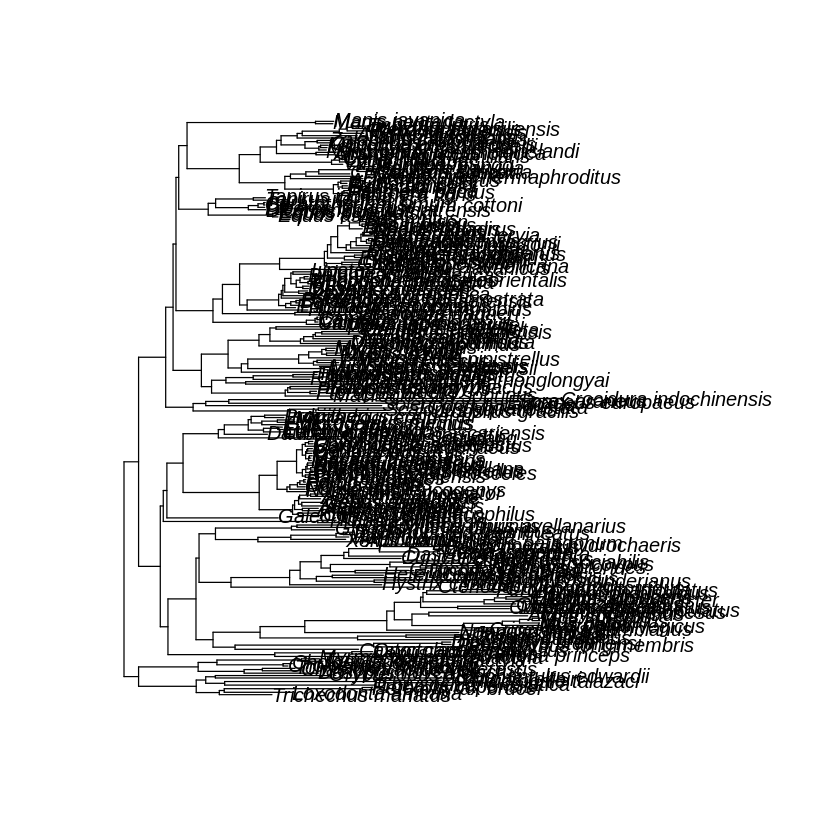

In [17]:
## Read in the zoonomia tree ###
zoonomiaTree <- read.tree(file = "Zoonomia_ChrX_lessGC40_241species_30Consensus.tree") #read tree in Newick format
zoonomiaTree
plot(zoonomiaTree, type = "phylogram", show.tip.label = TRUE,
     edge.color = "black", edge.width = 1, edge.lty = 1,
     tip.color = "black")

In [18]:
##########################################
##### Study how different types of evolutionary distances from mouse are associated #####
##########################################


	Pearson's product-moment correlation

data:  speciesInfoF[, "MouseSplit_MYA"] and speciesInfoF[, "MouseSplit_Cactus"]
t = 29.151, df = 220, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8605862 0.9154989
sample estimates:
      cor 
0.8912647 


`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


null device 
          1

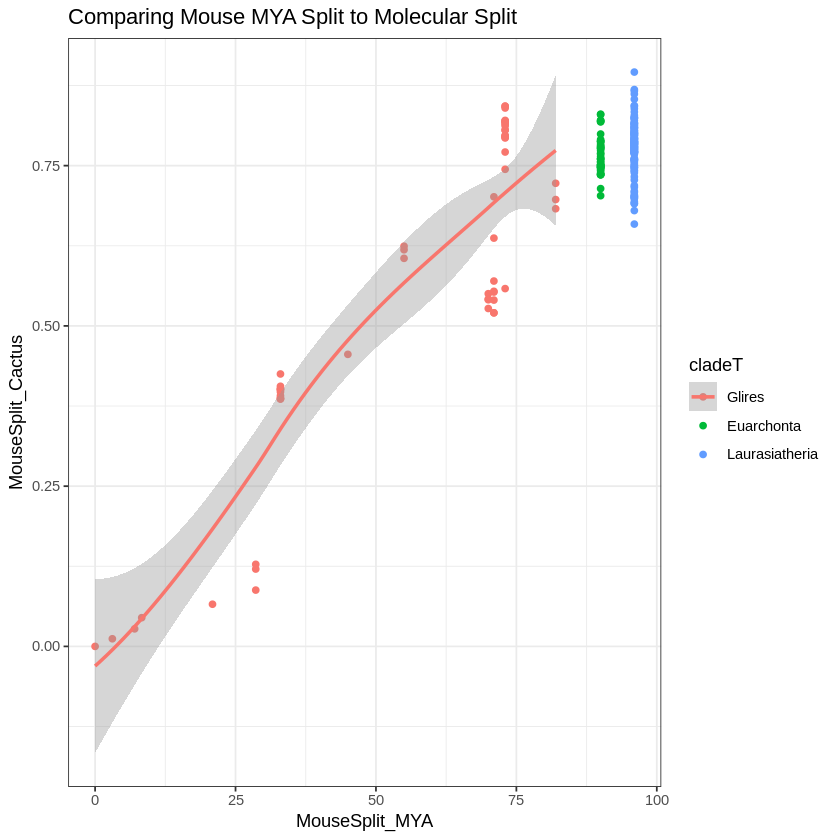

In [19]:
####### How is molecular distance associated with chronological distance? ########

## Create a corrleation ##
cor.test(speciesInfoF[,"MouseSplit_MYA"],speciesInfoF[,"MouseSplit_Cactus"] );

## Create a scatter plot ##
speciesPlotF <- speciesInfoF; #Create a new version of the dataframe to plot from
speciesPlotF$cladeT <- factor(speciesPlotF$Clade,levels=c("Glires","Euarchonta","Laurasiatheria")); #Turn clade into factor to better model it

curP <- ggplot(speciesPlotF, aes(x = MouseSplit_MYA , y = MouseSplit_Cactus, color=cladeT)) +
  geom_point() +
  geom_smooth(span=.75) +
  ggtitle("Comparing Mouse MYA Split to Molecular Split") +
  theme_bw();

print(curP);

dev.off();


In [20]:
#### Pearson correlation of evolutionary measures ####

avgChromatin <- colMeans(peakPredM, na.rm = TRUE)
avgChromatin <- avgChromatin[specOrderV]

# Check that lengths
print(length(avgChromatin))  # Should be 222
print(length(speciesInfoF[, "MouseSplit_MYA"]))  # Should be 222

# Run the correlation test
cor.test(avgChromatin, speciesInfoF[, "MouseSplit_MYA"])
cor.test(avgChromatin, speciesInfoF[, "MouseSplit_Cactus"])


[1] 222
[1] 222



	Pearson's product-moment correlation

data:  avgChromatin and speciesInfoF[, "MouseSplit_MYA"]
t = -31.343, df = 220, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9254289 -0.8765532
sample estimates:
       cor 
-0.9038996 



	Pearson's product-moment correlation

data:  avgChromatin and speciesInfoF[, "MouseSplit_Cactus"]
t = -27.76, df = 220, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9081970 -0.8489134
sample estimates:
       cor 
-0.8819976 


`geom_smooth()` using formula = 'y ~ x'


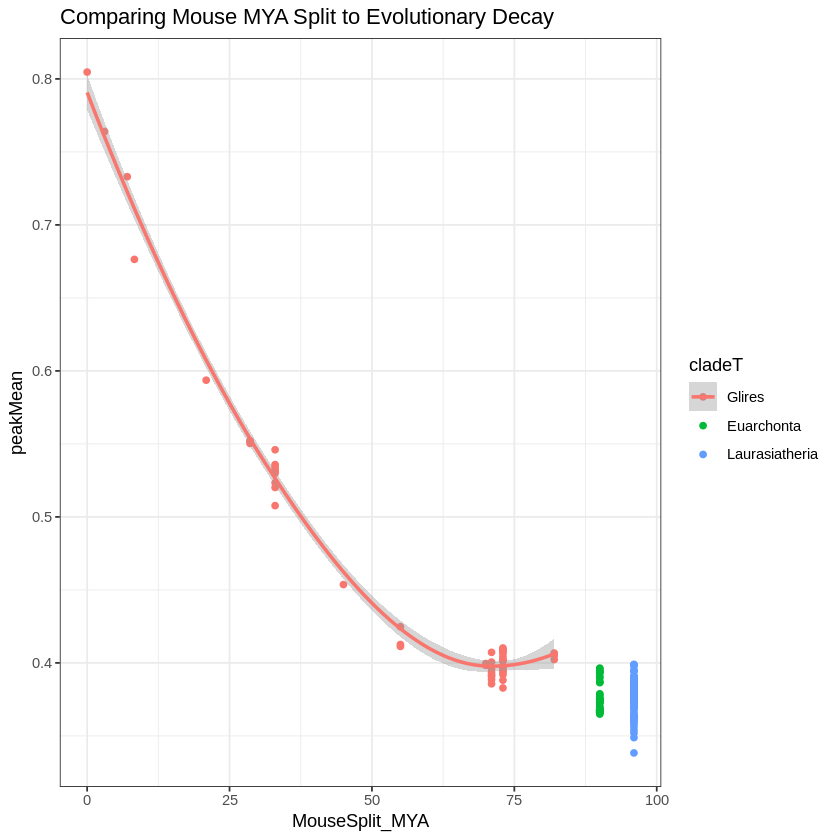

In [21]:
#### Compare evolutionary decay to MYA ####

## Create a scatter plot :
speciesPlotF <- speciesInfoF;  # Create a copy of the species info dataframe
speciesPlotF$cladeT <- factor(speciesPlotF$Clade, levels=c("Glires", "Euarchonta", "Laurasiatheria"));  # Convert Clade to a factor for coloring
speciesPlotF$peakMean <- avgChromatin;

# Generate the plot
curP <- ggplot(speciesPlotF, aes(x = MouseSplit_MYA, y = peakMean, color = cladeT)) +
  geom_point() +  # Add points
  geom_smooth(method = "loess", span = 0.75) +  # Add a LOESS smooth line
  ggtitle("Comparing Mouse MYA Split to Evolutionary Decay") +
  theme_bw();

print(curP);


`geom_smooth()` using formula = 'y ~ x'


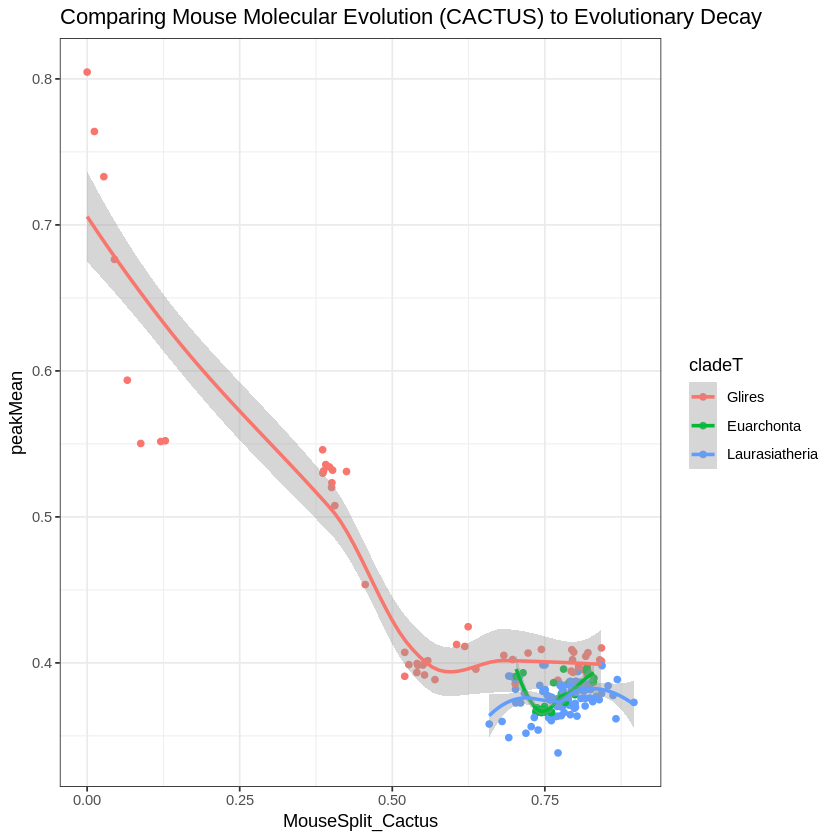

In [22]:
#### Compare evolutionary decay to molecular evolution ####

# Scatter plot for MouseSplit_Cactus and avgChromatin
speciesPlotF <- speciesInfoF;  # Create a copy of the species info dataframe
speciesPlotF$cladeT <- factor(speciesPlotF$Clade, levels=c("Glires", "Euarchonta", "Laurasiatheria"));  # Convert Clade to a factor for coloring
speciesPlotF$peakMean <- avgChromatin;

# Generate the plot
curP <- ggplot(speciesPlotF, aes(x = MouseSplit_Cactus, y = peakMean, color = cladeT)) +
  geom_point() +
  geom_smooth(method = "loess", span = 0.75) +
  ggtitle("Comparing Mouse Molecular Evolution (CACTUS) to Evolutionary Decay") +
  theme_bw();

print(curP);

MYA is based on fossil evidence and represents time elapsed, assuming constant evolutionary rates. On the other hand CACTUS refllects molecular evollution, which varies across species.
Molecular changes can occur at different rates due to certain factors like, mutatiion rates, genetic drift, etc., leading to differences in evolutionary distances.
MYA captures visible phenotypic changes, CACTUS includes both neutral and fuunctional mutations, justifying why molecular evolution may not align perfectly with chronological time.

In [23]:
##########################################
##### Compare datasources for building an evolutionary tree #####
##########################################

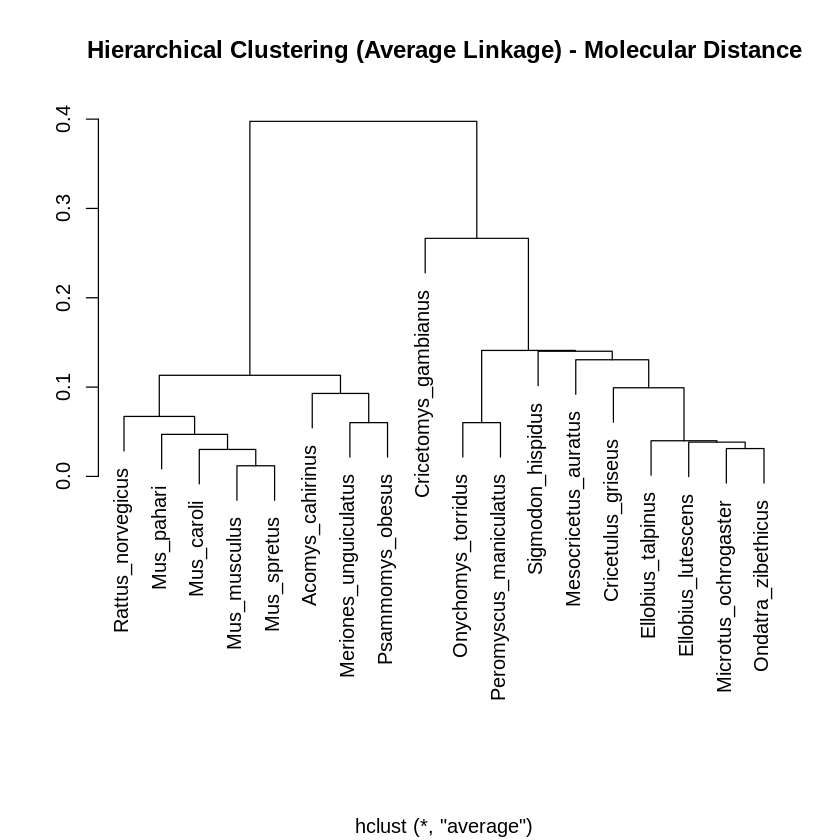

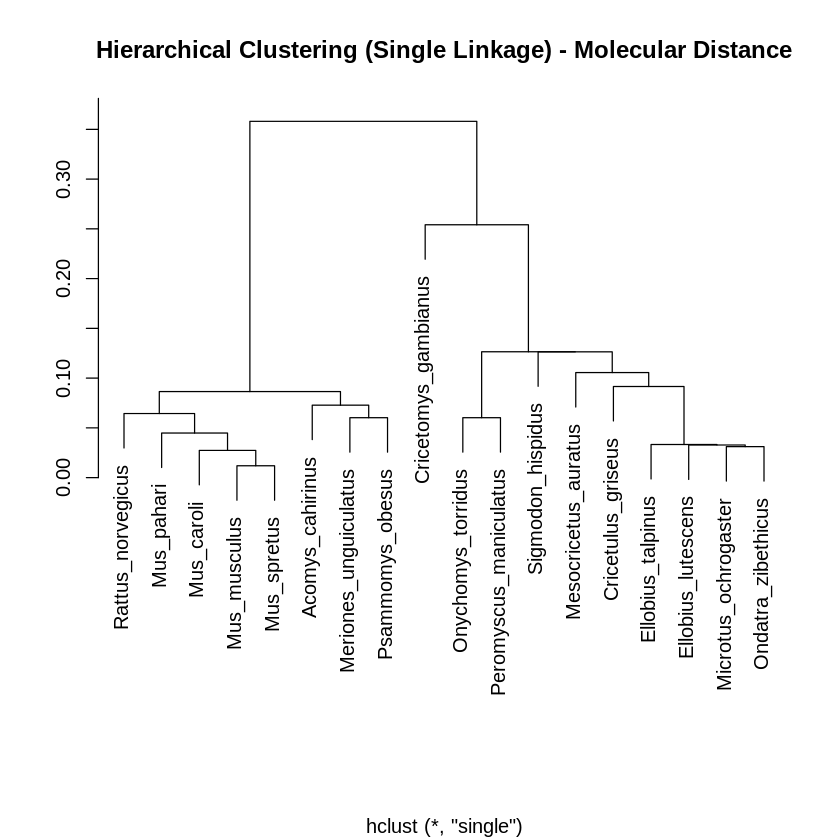

In [25]:
#### Compare evolutionary decay to molecular evolution ####

myaThresh <- 33
keepSpeciesV <- speciesInfoF[which(speciesInfoF$MouseSplit_MYA <= myaThresh), "Species"]

molecularDistSubM <- molecularDistM[keepSpeciesV, keepSpeciesV]
cactusSubDistD <- as.dist(molecularDistSubM)
# Average linkage hierarchical clustering
cactusSubCl_avg <- hclust(cactusSubDistD, method = "average")
plot(cactusSubCl_avg, main = "Hierarchical Clustering (Average Linkage) - Molecular Distance", xlab = "", ylab = "")
# Single linkage hierarchical clustering
cactusSubCl_single <- hclust(cactusSubDistD, method = "single")
plot(cactusSubCl_single, main = "Hierarchical Clustering (Single Linkage) - Molecular Distance", xlab = "", ylab = "")


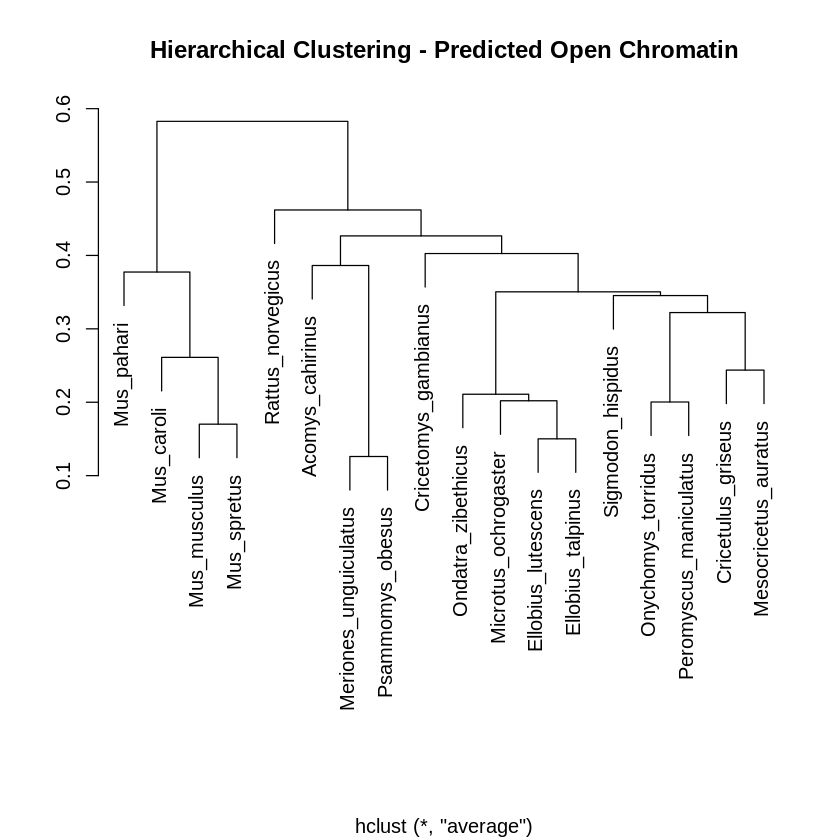

In [27]:
#### Build an evolutionary tree using predicted open chromatin ####

m1DistM <- 1-cor(peakPredM[,keepSpeciesV],use='pairwise.complete.obs')
m1DistD <- as.dist(m1DistM)
m1Cl <- hclust(m1DistD, method = "average")
plot(m1Cl, main = "Hierarchical Clustering - Predicted Open Chromatin", xlab = "", ylab = "")

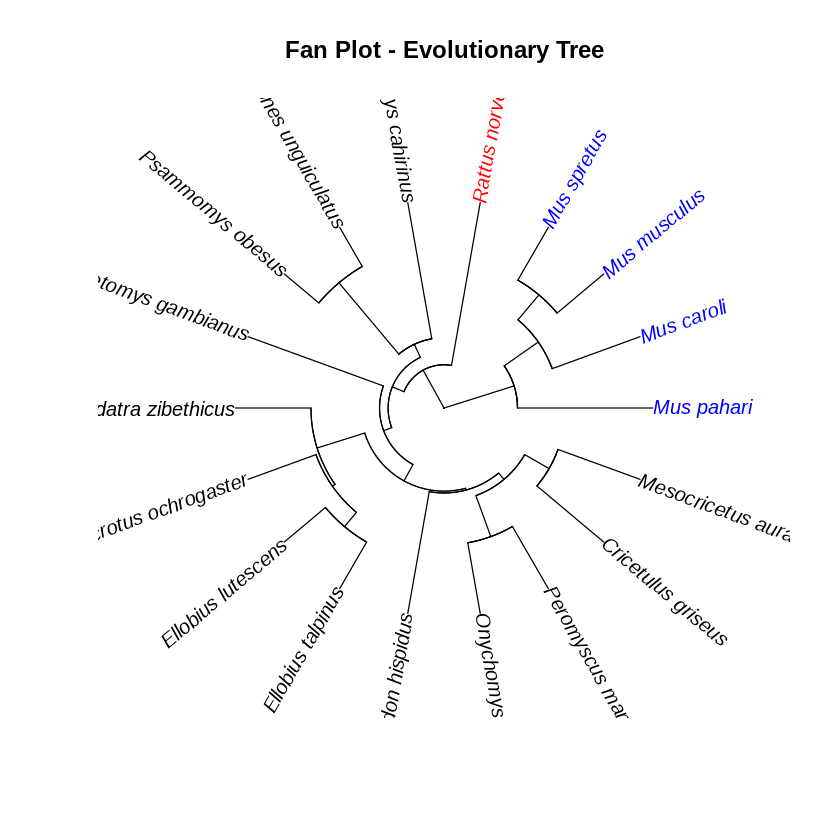

In [28]:
#### Visualize evolutionary tree in fan form ####

#### Update the tree to contain a binary category for being in the mus genus #####
speciesInfoF$mus <- "none";
speciesInfoF[which(speciesInfoF$MouseSplit_MYA <= 10),"mus"] <- "mus";
speciesInfoF[which(speciesInfoF$Species == "Rattus_norvegicus"),"mus"] <- "rat";

speciesInfoF$mus <- factor(speciesInfoF$mus,levels=c("none","mus","rat"));
m1ClTree <- as.phylo(m1Cl)
#### Add tip label depending on whether species is mus ######
tipColorsV <- ifelse(speciesInfoF[m1ClTree$tip.label, "mus"] == "mus", "blue",
                     ifelse(speciesInfoF[m1ClTree$tip.label, "mus"] == "rat", "red", "black"))
# Plot the tree in fan
plot(m1ClTree, type = "fan", show.tip.label = TRUE,
     edge.color = "black", edge.width = 1, edge.lty = 1,
     tip.color = tipColorsV, main = "Fan Plot - Evolutionary Tree")


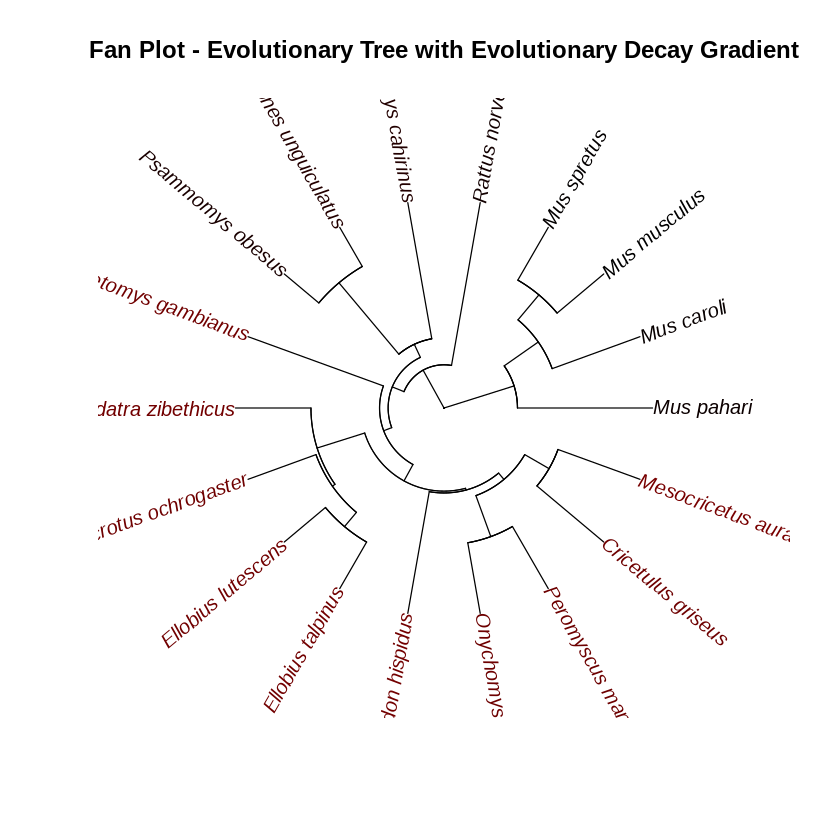

In [30]:
#### Visualize evolutionary tree in fan form ##############

# Scale MouseSplit_Cactus values to create a color gradient (0 to 1 scaling)
speciesInfoF$MouseSplit_Cactus_Scale <- scale(speciesInfoF$MouseSplit_Cactus, center = min(speciesInfoF$MouseSplit_Cactus), scale = max(speciesInfoF$MouseSplit_Cactus) - min(speciesInfoF$MouseSplit_Cactus))

# Convert the hierarchical clustering from 2B into a phylogenetic tree object
m1ClTree <- as.phylo(m1Cl)

# Create a color gradient from red (high evolutionary decay) to black (low evolutionary decay)
tipColorsM <- colorRamp(c("black", "red"))(speciesInfoF[m1ClTree$tip.label, "MouseSplit_Cactus_Scale"])

# Convert the matrix of RGB values to a color vector
tipColorsV <- apply(tipColorsM, 1, function(x) rgb(x[1], x[2], x[3], maxColorValue=255))

# Plot the tree in fan form, with tip labels colored based on evolutionary decay
plot(m1ClTree, type = "fan", show.tip.label = TRUE,
     edge.color = "black", edge.width = 1, edge.lty = 1,
     tip.color = tipColorsV, main = "Fan Plot - Evolutionary Tree with Evolutionary Decay Gradient")


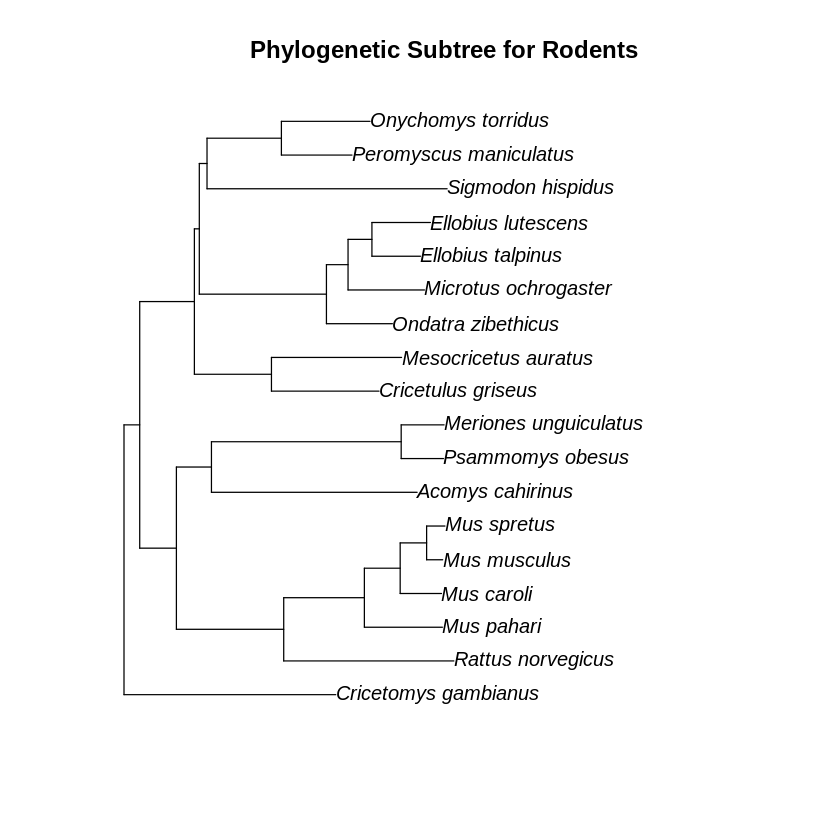

In [31]:

#Identify a subtree of interest for rodents
removeSpecV <- setdiff(zoonomiaTree$tip.label,keepSpeciesV);
rodentTree <- drop.tip(zoonomiaTree, removeSpecV)

plot(rodentTree, type = "phylogram", show.tip.label = TRUE,
     edge.color = "black", edge.width = 1, edge.lty = 1,
     tip.color = "black", main = "Phylogenetic Subtree for Rodents")

In [32]:
##########################################
##### Find human-accelerated regions of the genome based on predicted open chromatin #####
##########################################

In [33]:
### Set the species of interest ####
foregroundSpeciesV <- speciesInfoF[which(speciesInfoF$HumanSplit_MYA <= 7),"Species"]
backgroundSpeciesV <- speciesInfoF[which(speciesInfoF$HumanSplit_MYA > 7 & speciesInfoF$HumanSplit_MYA < 30),"Species"]


In [34]:
foregroundSpeciesV
backgroundSpeciesV

[1] "Homo_sapiens"    "Pan_paniscus"    "Pan_troglodytes"

[1] "Cercocebus_atys"           "Cercopithecus_neglectus"  
 [3] "Chlorocebus_sabaeus"       "Colobus_angolensis"       
 [5] "Erythrocebus_patas"        "Gorilla_gorilla"          
 [7] "Macaca_fascicularis"       "Macaca_mulatta"           
 [9] "Macaca_nemestrina"         "Mandrillus_leucophaeus"   
[11] "Nasalis_larvatus"          "Nomascus_leucogenys"      
[13] "Papio_anubis"              "Piliocolobus_tephrosceles"
[15] "Pongo_abelii"              "Pygathrix_nemaeus"        
[17] "Rhinopithecus_bieti"       "Rhinopithecus_roxellana"  
[19] "Semnopithecus_entellus"

In [35]:
#### Human Open Chromatin Prediction ####
# Foreground species (Human, Chimpanzee, Bonobo)
foregroundSpeciesV <- speciesInfoF[which(speciesInfoF$HumanSplit_MYA <= 7), "Species"]
# Background species (Other monkeys)
backgroundSpeciesV <- speciesInfoF[which(speciesInfoF$HumanSplit_MYA > 7 & speciesInfoF$HumanSplit_MYA < 30), "Species"]
# Initialize results data frame
resultsDF <- data.frame(PeakID = rownames(peakPredM), AvgDiff = NA, PValue = NA, AdjustedPValue = NA)
# Perform t-test for each peak
for (i in 1:nrow(peakPredM)) {
  fgValues <- peakPredM[i, foregroundSpeciesV]  # Predicted chromatin values for foreground species
  bgValues <- peakPredM[i, backgroundSpeciesV]  # Predicted chromatin values for background species
  # Remove missing values (NA)
  fgValues <- fgValues[!is.na(fgValues)]
  bgValues <- bgValues[!is.na(bgValues)]
  # Check if we have enough observations for the t-test
  if (length(fgValues) > 1 & length(bgValues) > 1) {
    # Perform t-test
    tResult <- t.test(fgValues, bgValues)
    # Store the results
    resultsDF$AvgDiff[i] <- mean(fgValues) - mean(bgValues)
    resultsDF$PValue[i] <- tResult$p.value
  } else {
    # If there aren't enough observations, skip the test
    resultsDF$AvgDiff[i] <- NA
    resultsDF$PValue[i] <- NA
  }
}
# Adjust p-values using the Benjamini-Hochberg method
resultsDF$AdjustedPValue <- p.adjust(resultsDF$PValue, method = "BH")
# Sort results by adjusted p-value
resultsDF <- resultsDF[order(resultsDF$AdjustedPValue), ]
# Print the most significant peak
print(resultsDF[1, ])
# Verify result by printing predicted open chromatin for foreground and background species
fgPred <- peakPredM[rownames(peakPredM) == resultsDF$PeakID[1], foregroundSpeciesV]
bgPred <- peakPredM[rownames(peakPredM) == resultsDF$PeakID[1], backgroundSpeciesV]
print(fgPred)
print(bgPred)


            PeakID   AvgDiff       PValue AdjustedPValue
18910 peak30619_mo 0.6543382 3.916641e-20    1.32359e-15
   Homo_sapiens    Pan_paniscus Pan_troglodytes 
      0.8556695       0.8455845       0.8409030 
          Cercocebus_atys   Cercopithecus_neglectus       Chlorocebus_sabaeus 
                0.2990390                 0.2131100                 0.1457480 
       Colobus_angolensis        Erythrocebus_patas           Gorilla_gorilla 
                0.2014480                 0.1661145                 0.3303840 
      Macaca_fascicularis            Macaca_mulatta         Macaca_nemestrina 
                0.1542215                 0.0914970                 0.1806820 
   Mandrillus_leucophaeus          Nasalis_larvatus       Nomascus_leucogenys 
                0.1165960                 0.1536195                 0.2954255 
             Papio_anubis Piliocolobus_tephrosceles              Pongo_abelii 
                0.1476570                 0.1408650                 0.3335255

In [36]:
#Print out peaks to a bed file
# Create a data frame for the peak with its genomic coordinates
significantPeak <- peakInfoF[rownames(peakInfoF) == resultsDF$PeakID[1], ]

# Define the columns for the BED file (chromosome, start, end, and peak ID)
bedData <- data.frame(
  chr = significantPeak$chr,
  start = significantPeak$start,
  end = significantPeak$stop,
  name = significantPeak$id
)

# Write the BED file
write.table(bedData, file="BedFile.bed", quote=FALSE, sep="\t", row.names=FALSE, col.names=FALSE)

peakInfoF["peak30619_mo",]


,chr,start,stop,id
,<chr>,<int>,<int>,<chr>
peak30619_mo,chr2,180928426,180928826,peak30619_mo


In [37]:
#### Longevity Association ####
longevityF <- read.csv("pantheriaLongevity.csv",stringsAsFactors = F,na.strings = c("-999","NA"));
longevityF$Species <- gsub(" ","_",longevityF$Species)

# Extract the longevity values from the column X17_MaxLongevity
longevityV <- longevityF$X17_MaxLongevity
# Assign the species names to the longevity values vector
names(longevityV) <- longevityF$Species

# Check the first 5 values of the longevity vector
longevityV[1:5]

# Add the longevity data to the speciesInfoF dataframe
speciesDetailedInfoF <- speciesInfoF
speciesDetailedInfoF$longevity <- longevityV[match(speciesDetailedInfoF$Species, names(longevityV))]


Canis_lupus       Ceratotherium_simum    Pontoporia_blainvillei 
                    354.0                     600.0                     192.0 
    Macrotus_californicus Rhinolophus_ferrumequinum 
                    124.8                     360.0

In [38]:
#### Phylolm ####
#Create a new dataframe with the relevant information
subSpeciesF <- speciesInfoF[c(foregroundSpeciesV,backgroundSpeciesV),];

fgLongevity <- speciesDetailedInfoF$longevity[match(foregroundSpeciesV, speciesDetailedInfoF$Species)]
bgLongevity <- speciesDetailedInfoF$longevity[match(backgroundSpeciesV, speciesDetailedInfoF$Species)]

subSpeciesF$longevity <- c(fgLongevity,bgLongevity);
subSpeciesF$curEnhancer <- peakPredM["peak30619_mo",subSpeciesF$Species]

subSpeciesF[1:5,]


,ZoonomiaIndex,Species,CommonName,Clade,MouseSplit_Cactus,MouseSplit_MYA,HumanSplit_MYA,CN50_kb,Scaffold.N50,Scaffold.L50,Contig.N50,Contig.L50,Assembly,mus,MouseSplit_Cactus_Scale,longevity,curEnhancer
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,"<dbl[,1]>",<dbl>,<dbl>
Homo_sapiens,55,Homo_sapiens,Human,Euarchonta,0.73560,90,0.00,56413054,67794873,16,56413054,19,GCA_000001405.27,none,0.8209913,1470.0,0.8556695
Pan_paniscus,94,Pan_paniscus,Bonobo,Euarchonta,0.73600,90,6.40,66676,8197324,94,66676,11048,GCF_000258655.2,none,0.8214377,576.0,0.8455845
Pan_troglodytes,95,Pan_troglodytes,Common Chimpanzee,Euarchonta,0.73603,90,6.40,12421315,53103722,19,12268567,67,GCA_002880755.3,none,0.8214712,720.0,0.8409030
Cercocebus_atys,24,Cercocebus_atys,Sooty Mangabey,Euarchonta,0.74702,90,28.81,112942,12849131,66,112942,6930,GCF_000955945.1,none,0.8337370,321.6,0.2990390
Cercopithecus_neglectus,140,Cercopithecus_neglectus,De Brazza's Monkey,Euarchonta,0.74952,90,28.81,13610,10270,72117,9789,78265,DISCOVAR (GCA_004027615.1),none,0.8365272,315.6,0.2131100


In [39]:
# Calculate mean longevity for foreground and background species
meanLongevityFg <- mean(fgLongevity, na.rm = TRUE)
meanLongevityBg <- mean(bgLongevity, na.rm = TRUE)
longevityDifference <- meanLongevityFg - meanLongevityBg

# Print the values
cat("Mean Longevity Foreground: ", meanLongevityFg, "\n")
cat("Mean Longevity Background: ", meanLongevityBg, "\n")
cat("Difference in Longevity: ", longevityDifference, "\n")

Mean Longevity Foreground:  922 
Mean Longevity Background:  368.9 
Difference in Longevity:  553.1 


In [40]:
#Load the package
install.packages("phylolm");
library(phylolm)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘future.apply’




                        ZoonomiaIndex                 Species
Homo_sapiens                       55            Homo_sapiens
Pan_paniscus                       94            Pan_paniscus
Pan_troglodytes                    95         Pan_troglodytes
Cercocebus_atys                    24         Cercocebus_atys
Cercopithecus_neglectus           140 Cercopithecus_neglectus
Chlorocebus_sabaeus                26     Chlorocebus_sabaeus
                                CommonName      Clade MouseSplit_Cactus
Homo_sapiens                         Human Euarchonta           0.73560
Pan_paniscus                        Bonobo Euarchonta           0.73600
Pan_troglodytes          Common Chimpanzee Euarchonta           0.73603
Cercocebus_atys             Sooty Mangabey Euarchonta           0.74702
Cercopithecus_neglectus De Brazza's Monkey Euarchonta           0.74952
Chlorocebus_sabaeus           Green Monkey Euarchonta           0.74811
                        MouseSplit_MYA HumanSplit_MYA  CN50_kb

Warning message in phylolm(curEnhancer ~ longevity, data = subSpeciesF, phy = monkeyTree, :
“will drop from the tree 7 taxa with missing data”



Call:
phylolm(formula = curEnhancer ~ longevity, data = subSpeciesF, 
    phy = monkeyTree, model = "BM")

    AIC  logLik 
-11.328   8.664 

Raw residuals:
     Min       1Q   Median       3Q      Max 
-0.28700 -0.19777 -0.16349 -0.07545  0.43529 

Mean tip height: 0.02639247
Parameter estimate(s) using ML:
sigma2: 2.239557 

Coefficients:
              Estimate     StdErr t.value p.value
(Intercept) 0.28311505 0.18000298  1.5728  0.1398
longevity   0.00022080 0.00014851  1.4868  0.1609

R-squared: 0.1453	Adjusted R-squared: 0.07958 

P-value: 0.1609218 
R-squared: 0.1453269

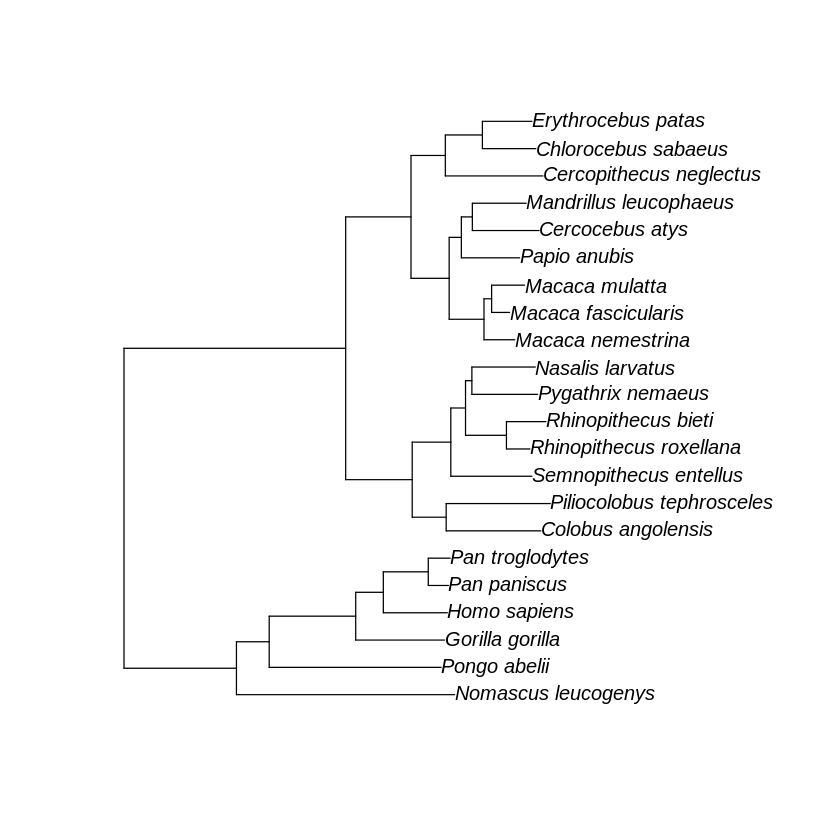

In [41]:
#Create a data frame with all the information (peak prediction, longevity, species);

# Create a dataframe with the species, longevity, and peak prediction (curEnhancer)
subSpeciesF <- speciesInfoF[c(foregroundSpeciesV, backgroundSpeciesV), ]  # Subset for foreground and background species
subSpeciesF$longevity <- c(fgLongevity, bgLongevity)
subSpeciesF$curEnhancer <- peakPredM["peak30619_mo", subSpeciesF$Species]

print(head(subSpeciesF))

#Create a new phylogenetic tree with just the monkeys
monkeyTree <- drop.tip(zoonomiaTree, setdiff(zoonomiaTree$tip.label, c(foregroundSpeciesV, backgroundSpeciesV)))
plot(monkeyTree, show.tip.label = TRUE)

#Run phylolm for the top peak
phylolm_result <- phylolm(curEnhancer ~ longevity, data = subSpeciesF, phy = monkeyTree, model = "BM")
summary(phylolm_result)
p_value <- summary(phylolm_result)$coefficients["longevity", "p.value"]
r_squared <- summary(phylolm_result)$r.squared
cat("P-value:", p_value, "\nR-squared:", r_squared)

Warning message:
“Removed 80 rows containing non-finite outside the scale range
(`stat_smooth()`).”
Warning message:
“Removed 80 rows containing missing values or values outside the scale range
(`geom_point()`).”


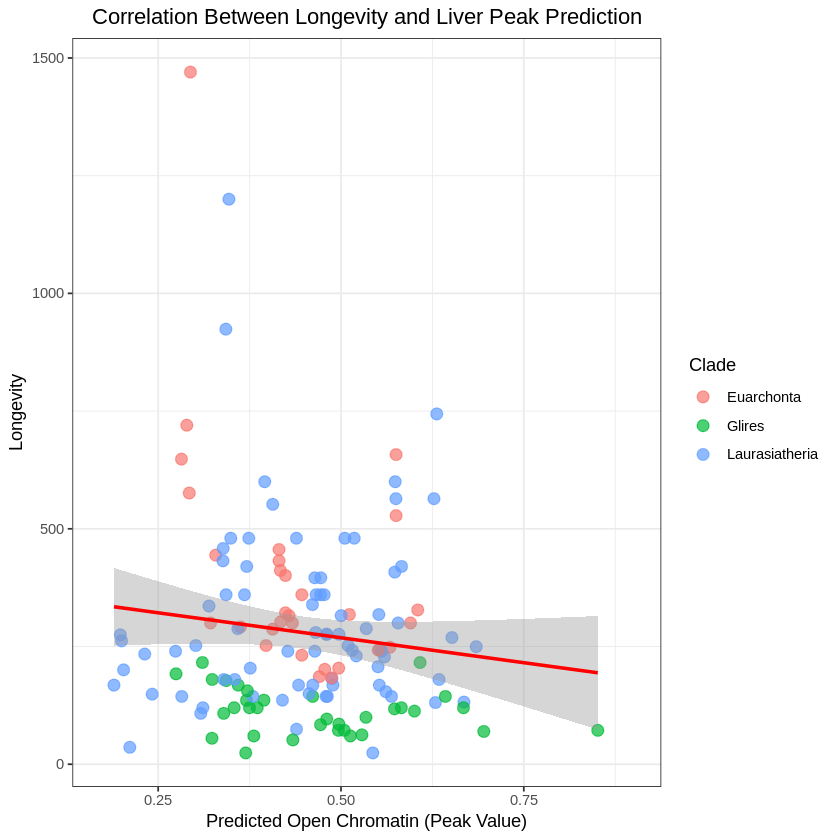

In [42]:
# Set the current peak for analysis
curPeak <- "peak339_mo"

# Copy the species info dataframe and add the current peak values to it
speciesDetailedInfoTmpF <- speciesDetailedInfoF
speciesDetailedInfoTmpF$curPeak <- peakPredM[curPeak, ]

# Create the scatter plot with ggplot2
curP <- ggplot(speciesDetailedInfoTmpF, aes(x = curPeak, y = longevity, color = Clade)) +
  geom_point(size = 3, alpha = 0.7) +  # Scatter points with size and transparency
  geom_smooth(method = 'lm', formula = y ~ x, color = "red") +  # Linear regression line
  labs(title = "Correlation Between Longevity and Liver Peak Prediction",
       x = "Predicted Open Chromatin (Peak Value)",
       y = "Longevity") +  # Add labels
  theme_bw() +  # Minimalistic theme
  theme(plot.title = element_text(hjust = 0.5))  # Center-align the title

# Print the scatter plot
print(curP)